<a href="https://colab.research.google.com/github/Zypher44/RaduIntuneric/blob/master/Tensorflow_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Jul 10 23:31:45 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py


--2021-07-10 23:32:23--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2021-07-10 23:32:24 (88.1 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [38]:
from helper_functions import make_confusion_matrix, pred_and_plot, create_tensorboard_callback, compare_historys, unzip_data, walk_through_dir, calculate_results, plot_loss_curves

In [16]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip

unzip_data("101_food_classes_10_percent.zip")

train_dir = '101_food_classes_10_percent/train'
test_dir = "101_food_classes_10_percent/test"

--2021-07-10 23:39:11--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.195.128, 74.125.142.128, 173.194.203.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.195.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip.2’

101_food_classes_10 100%[===================>]   1.51G   157MB/s    in 7.8s    

2021-07-10 23:39:19 (198 MB/s) - ‘101_food_classes_10_percent.zip.2’ saved [1625420029/1625420029]



In [21]:
#Set up inputs with image dataset from directory 
import tensorflow as tf
from tensorflow import keras

print("Train Data")
train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                 label_mode='categorical',
                                                                 image_size=(224,224))


print("Test Data")
test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                label_mode="categorical",
                                                                image_size=(224,224)
)

Train Data
Found 7575 files belonging to 101 classes.
Test Data
Found 25250 files belonging to 101 classes.


In [25]:
#Augmenting our data 

data_augmentation = tf.keras.Sequential([
      tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
      tf.keras.layers.experimental.preprocessing.RandomWidth(0.2),
      tf.keras.layers.experimental.preprocessing.RandomZoom(0.2),
      tf.keras.layers.experimental.preprocessing.RandomHeight(0.2)
], name="DataAugmentation")



In [28]:
#Create callbacks
checkpoint_path = "101_food_classes_10_percent_data_model_checkpoint"

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         monitor='val_accuracy',
                                                         save_best_only=True,
                                                         save_weights_only=True)

In [33]:
#Create model setup basemodel and freeze its layer Feature extraction 

base_model = tf.keras.applications.EfficientNetB0(include_top=False) #DOnt want top layers 
base_model.trainable=False

#Make a model with trainable top layers 

inputs = tf.keras.layers.Input(shape=(224,224,3),name='Input_layer')

x = data_augmentation(inputs)
x = base_model(x,training=False) #Training false puts model in inferance mode so frozen weights stay forzen
x = tf.keras.layers.GlobalAveragePooling2D(name="GlobalAveragePooling")(x)

outputs = tf.keras.layers.Dense(len(train_data.class_names),activation='softmax',name="outputlayer")(x)

model = tf.keras.Model(inputs,outputs)

In [35]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
DataAugmentation (Sequential (None, None, None, 3)     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
GlobalAveragePooling (Global (None, 1280)              0         
_________________________________________________________________
outputlayer (Dense)          (None, 101)               129381    
Total params: 4,178,952
Trainable params: 129,381
Non-trainable params: 4,049,571
_________________________________________________________________


In [36]:
model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer = tf.keras.optimizers.Adam(),
    metrics = ['accuracy']
)

In [37]:
history = model.fit(
    train_data,
    epochs=10,
    callbacks=checkpoint_callback, 
    steps_per_epoch = len(train_data),
    validation_data = test_data,
    validation_steps = int(0.15*len(test_data))
)

Epoch 1/10
237/237 [==============================] - 122s 370ms/step - loss: 3.4207 - accuracy: 0.2504 - val_loss: 2.4280 - val_accuracy: 0.4584
Epoch 2/10
237/237 [==============================] - 71s 296ms/step - loss: 2.2826 - accuracy: 0.4766 - val_loss: 1.9863 - val_accuracy: 0.5236
Epoch 3/10
237/237 [==============================] - 66s 277ms/step - loss: 1.9006 - accuracy: 0.5476 - val_loss: 1.8104 - val_accuracy: 0.5519
Epoch 4/10
237/237 [==============================] - 63s 264ms/step - loss: 1.6860 - accuracy: 0.5956 - val_loss: 1.7360 - val_accuracy: 0.5651
Epoch 5/10
237/237 [==============================] - 58s 243ms/step - loss: 1.5280 - accuracy: 0.6337 - val_loss: 1.6747 - val_accuracy: 0.5744
Epoch 6/10
237/237 [==============================] - 55s 233ms/step - loss: 1.3977 - accuracy: 0.6552 - val_loss: 1.6382 - val_accuracy: 0.5826
Epoch 7/10
237/237 [==============================] - 54s 226ms/step - loss: 1.2848 - accuracy: 0.6870 - val_loss: 1.6288 - val_a

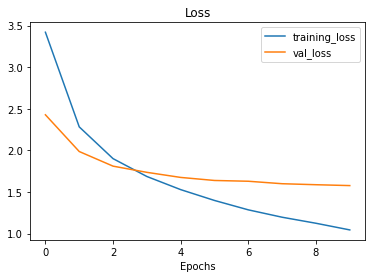

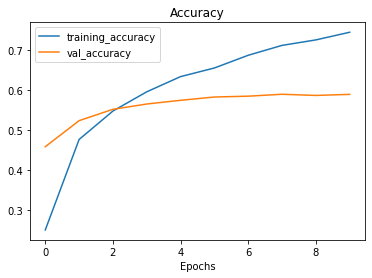

In [39]:
plot_loss_curves(history)

In [40]:
feature_Extraction = model.evaluate(test_data)

790/790 [==============================] - 89s 112ms/step - loss: 1.5669 - accuracy: 0.5849


Fine Tuning




In [63]:
base_model.trainable=True

#Refrezze every layer but the last 5 

for layer in base_model.layers[:-5]:
  layer.trainable=False

In [64]:
#Compile new model with smaller learning rate

model.compile(
    loss = tf.keras.losses.CategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    metrics = ['accuracy']
)

In [65]:
for layer in model.layers:
  print(layer.name, layer.trainable)

Input_layer True
DataAugmentation True
efficientnetb0 True
GlobalAveragePooling True
outputlayer True


In [66]:
#Check the trainable layers in our basemodel 

for layer_number, layer in enumerate(base_model.layers):
  print(layer_number,layer.name, layer.trainable)


0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv_pad False
4 stem_conv False
5 stem_bn False
6 stem_activation False
7 block1a_dwconv False
8 block1a_bn False
9 block1a_activation False
10 block1a_se_squeeze False
11 block1a_se_reshape False
12 block1a_se_reduce False
13 block1a_se_expand False
14 block1a_se_excite False
15 block1a_project_conv False
16 block1a_project_bn False
17 block2a_expand_conv False
18 block2a_expand_bn False
19 block2a_expand_activation False
20 block2a_dwconv_pad False
21 block2a_dwconv False
22 block2a_bn False
23 block2a_activation False
24 block2a_se_squeeze False
25 block2a_se_reshape False
26 block2a_se_reduce False
27 block2a_se_expand False
28 block2a_se_excite False
29 block2a_project_conv False
30 block2a_project_bn False
31 block2b_expand_conv False
32 block2b_expand_bn False
33 block2b_expand_activation False
34 block2b_dwconv False
35 block2b_bn False
36 block2b_activation False
37 block2b_se_squeeze False
38 block2b_se_resha

In [71]:
#Fine tune to 5 more epochs 

inital_epoch = 15

fine_tuning = model.fit(
    train_data,
    epochs=inital_epoch,
    validation_data = test_data,
    validation_steps = int(0.15*len(test_data)),
    initial_epoch=history.epoch[-1]
)

Epoch 10/15
237/237 [==============================] - 53s 220ms/step - loss: 0.8761 - accuracy: 0.7741 - val_loss: 1.5861 - val_accuracy: 0.5890
Epoch 11/15
237/237 [==============================] - 48s 201ms/step - loss: 0.7772 - accuracy: 0.7954 - val_loss: 1.6015 - val_accuracy: 0.5861
Epoch 12/15
237/237 [==============================] - 48s 202ms/step - loss: 0.7249 - accuracy: 0.8112 - val_loss: 1.5795 - val_accuracy: 0.5956
Epoch 13/15
237/237 [==============================] - 49s 204ms/step - loss: 0.6782 - accuracy: 0.8213 - val_loss: 1.5965 - val_accuracy: 0.5956
Epoch 14/15
237/237 [==============================] - 47s 198ms/step - loss: 0.6223 - accuracy: 0.8366 - val_loss: 1.6009 - val_accuracy: 0.5938
Epoch 15/15
237/237 [==============================] - 47s 195ms/step - loss: 0.5697 - accuracy: 0.8537 - val_loss: 1.6258 - val_accuracy: 0.5969


In [72]:
fine_tuning_results = model.evaluate(test_data)

790/790 [==============================] - 89s 112ms/step - loss: 1.5876 - accuracy: 0.5946


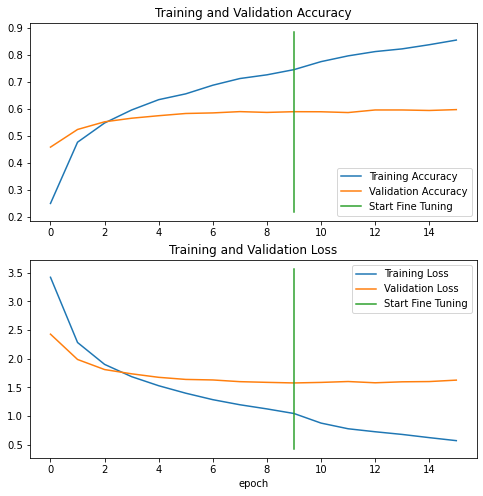

In [76]:
compare_historys(history,fine_tuning,initial_epochs=10)